In [23]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [25]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-12-20 15:18:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-12-20 15:18:02 (146 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [26]:
model = Sequential()
model.add(Embedding(total_words, 128, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1024, activation="relu", kernel_regularizer=regularizers.L2(), bias_regularizer=regularizers.L2()))
model.add(Dense(total_words, activation="softmax"))
# Pick an optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
print(model.summary())


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 10, 128)           411008    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 10, 200)           183200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100)               100400    
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_7 (Dense)              (None, 3211)              3291275   
Total params: 4,089,307
Trainable params: 4,089,307
Non-trainable params: 0
____________________________________________

In [27]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 11s 14ms/step - loss: 7.3850 - accuracy: 0.0196
Epoch 2/100
484/484 [==============================] - 7s 14ms/step - loss: 6.5127 - accuracy: 0.0201
Epoch 3/100
484/484 [==============================] - 7s 14ms/step - loss: 6.3759 - accuracy: 0.0241
Epoch 4/100
484/484 [==============================] - 7s 14ms/step - loss: 6.2650 - accuracy: 0.0307
Epoch 5/100
484/484 [==============================] - 7s 14ms/step - loss: 6.1360 - accuracy: 0.0344
Epoch 6/100
484/484 [==============================] - 7s 14ms/step - loss: 6.0797 - accuracy: 0.0398
Epoch 7/100
484/484 [==============================] - 7s 14ms/step - loss: 5.9750 - accuracy: 0.0431
Epoch 8/100
484/484 [==============================] - 7s 14ms/step - loss: 5.9236 - accuracy: 0.0450
Epoch 9/100
484/484 [==============================] - 7s 14ms/step - loss: 5.8127 - accuracy: 0.0494
Epoch 10/100
484/484 [==============================] - 7s 14ms/step - loss: 5.71

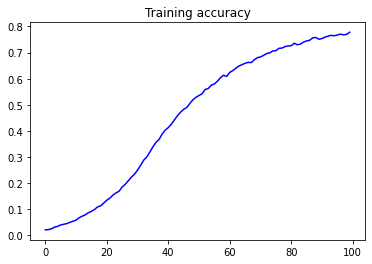

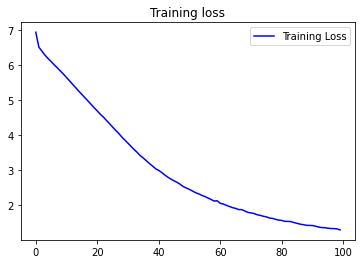

In [28]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [29]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Help me Obi Wan Kenobi, you're my only hope will bear self share best grow exchanged decays clearer ' dead light ' chide thee doth give shown brought a height away cherish cherish cherish cherish cherish cherish torn bide at mind thought women's blessed ear live doth bow bow seen fullness score twain twain fight taken brought to dross dross other dead grow bars lies bereft bereft bereft burn work's staineth burn'd drink thee doth ghastly day me razed gone as say thy treasure tongue ' none ' behind express'd brought to shown date light light bide each gems gems light dyed dyed burn rage express'd rare threw lived
